In [ ]:
!pip install zuko

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

Using device: cuda
Loaded model configuration: {'summary_dim': 50, 'context_dim': 50, 'dim': 2, 'num_blocks': 8, 'hidden_dim': 256, 'num_bins': 8}
Pre-trained model loaded successfully
True parameters: lengthscale=0.7500, variance=0.8000
Estimated parameters: lengthscale=1.3370, variance=1.0884


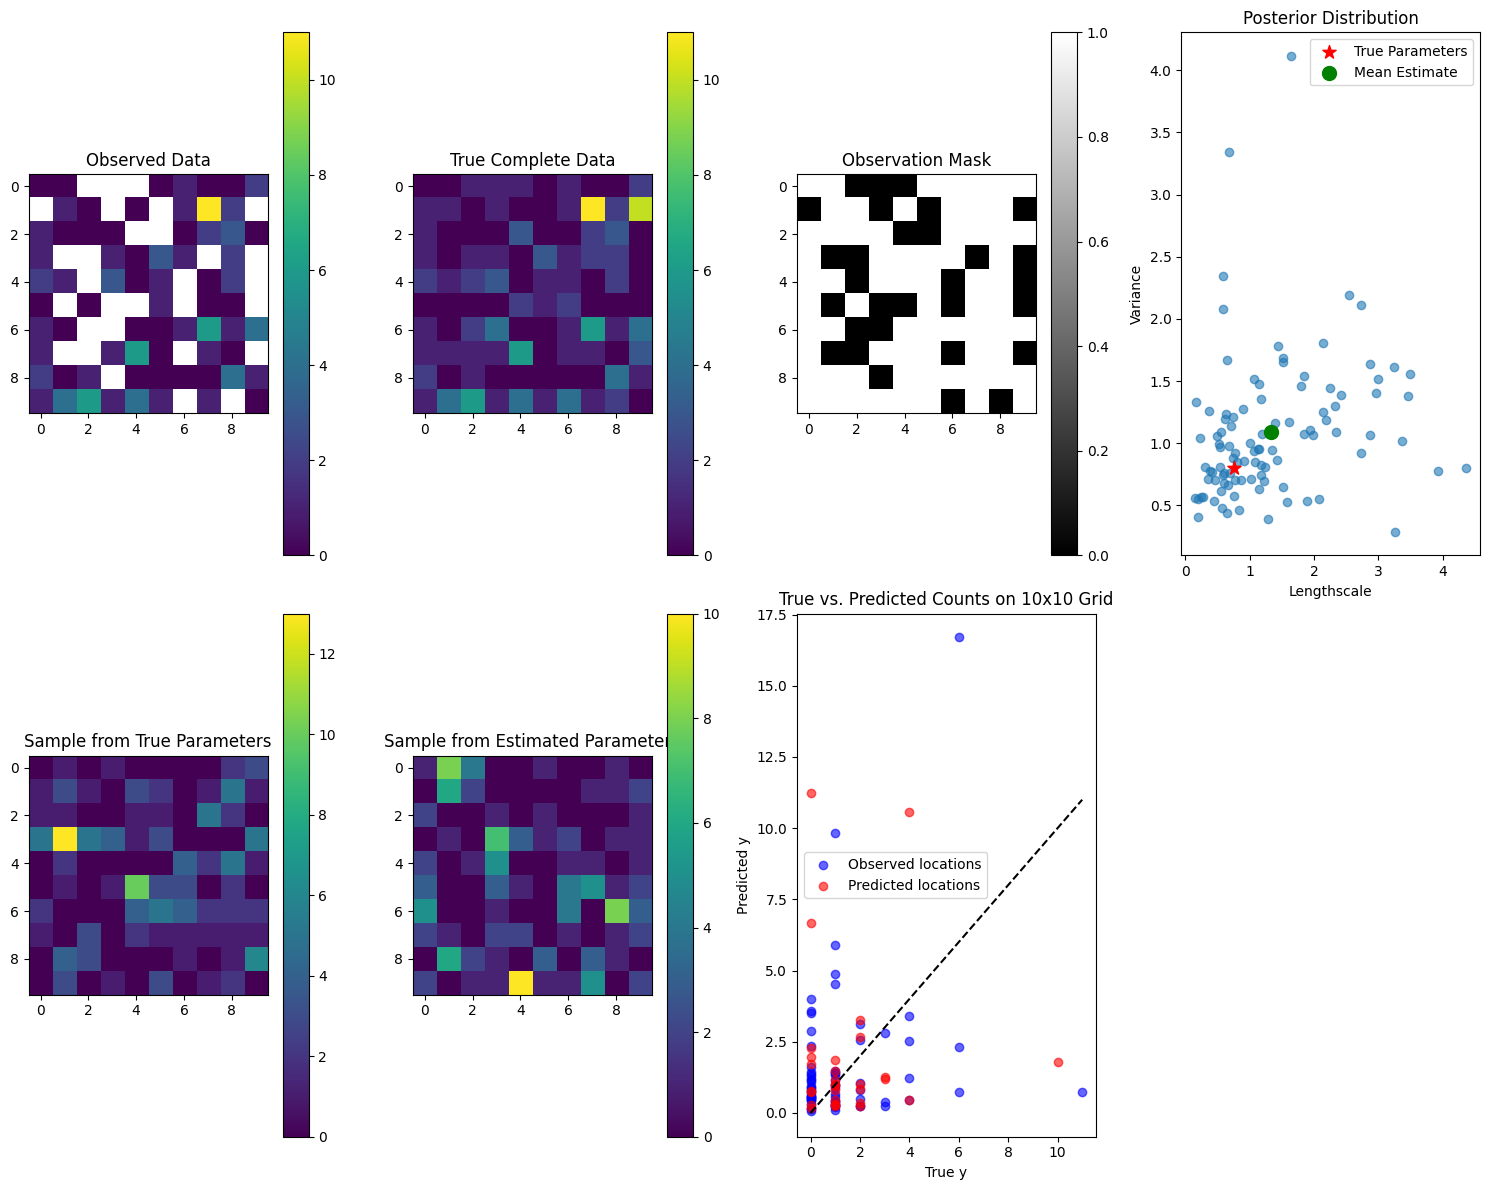

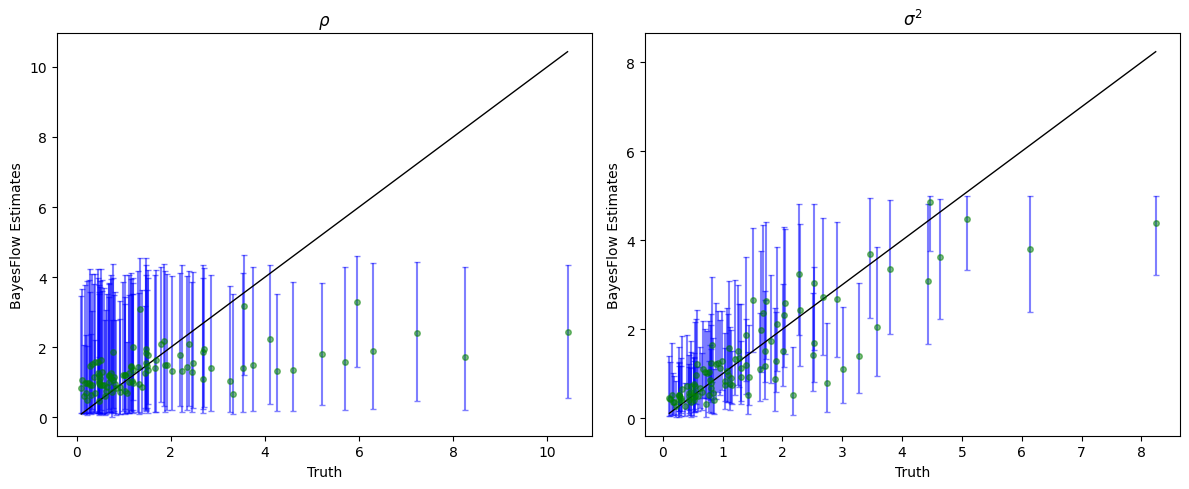

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import zuko

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

###########################################################
# 0. SIMULATION SETUP (Pure NumPy implementation)
###########################################################
grid_size = 10
x = np.stack(np.meshgrid(np.linspace(0, 10, grid_size),
                         np.linspace(0, 10, grid_size)), axis=-1).reshape(-1, 2)
n = x.shape[0]

def exponential_covariance_np(x1, x2, lengthscale=1.0, variance=1.0):
    dists = cdist(x1, x2)
    return variance * np.exp(-dists / lengthscale)

def sample_prior_np(batch_size=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    ls = np.exp(np.random.normal(0, 1, size=(batch_size,)))
    var = np.exp(np.random.normal(0, 1, size=(batch_size,)))
    return np.stack([ls, var], axis=-1)

def simulate_lgcp_np(params, seed=None):
    if seed is not None:
        np.random.seed(seed)
    batch_size = params.shape[0]
    data_out = []

    for i in range(batch_size):
        ls_i, var_i = params[i, 0], params[i, 1]
        cov = exponential_covariance_np(x, x, lengthscale=ls_i, variance=var_i)
        cov = cov + 1e-6 * np.eye(n)
        try:
            L = np.linalg.cholesky(cov)
            latent = np.dot(L, np.random.normal(size=n))
        except np.linalg.LinAlgError:
            latent = np.random.multivariate_normal(np.zeros(n), cov)
        counts = np.random.poisson(np.exp(latent))
        data_out.append(counts)
    return np.stack(data_out, axis=0)

def mask_data_np(full_data, obs_fraction=0.7, seed=None):
    if seed is not None:
        np.random.seed(seed)
    batch_size, n_points = full_data.shape
    out_data, out_masks = [], []
    for i in range(batch_size):
        counts_i = full_data[i]
        perm = np.random.permutation(n_points)
        n_obs = int(obs_fraction * n_points)
        obs_idx = perm[:n_obs]
        mask = np.zeros_like(counts_i)
        masked = -np.ones_like(counts_i)
        mask[obs_idx] = 1
        masked[obs_idx] = counts_i[obs_idx]
        out_data.append(masked)
        out_masks.append(mask)
    return np.stack(out_data), np.stack(out_masks)

###########################################################
# 1. Summary Network (CNN)
###########################################################
class ConvSummaryNet(nn.Module):
    def __init__(self, summary_dim=32):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(32, summary_dim)

    def forward(self, x_counts, x_mask):
        if x_counts.dim() == 2:
            B = x_counts.size(0)
            x_counts = x_counts.view(B, 10, 10)
            x_mask = x_mask.view(B, 10, 10)
        x = torch.stack([x_counts, x_mask], dim=1)  # [B, 2, 10, 10]
        h = self.cnn(x)

        downsampled_mask = nn.functional.interpolate(x_mask.unsqueeze(1), size=h.shape[-2:], mode='nearest')  # [B, 1, H, W]

        masked_h = h * downsampled_mask  # [B, 32, H, W]
        sum_mask = downsampled_mask.sum(dim=[2, 3], keepdim=True).clamp(min=1e-6)
        pooled = masked_h.sum(dim=[2, 3], keepdim=True) / sum_mask  # [B, 32, 1, 1]

        return self.fc(pooled.view(pooled.size(0), -1))  # [B, summary_dim]


###########################################################
# 2. Zuko NSF Flow
###########################################################
def build_nsf_flow(context_dim, dim=2, num_blocks=5, hidden_dim=128, num_bins=8, device=None):
    """
    Build a Neural Spline Flow on the specified device.
    If device is None, defaults to the current device.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    flow = zuko.flows.NSF(
        features=dim,
        context=context_dim,
        bins=num_bins,
        transforms=num_blocks,
        hidden_features=[hidden_dim] * num_blocks
    ).to(device)

    return flow

###########################################################
# 3. Dataset
###########################################################
class LGCPDataset(data.Dataset):
    def __init__(self, num_samples=200, cache_size=100):
        self.num_samples = num_samples
        self.cache_size = min(cache_size, num_samples)
        base_seed = 42
        self.cached_params = sample_prior_np(self.cache_size, seed=base_seed)
        raw_counts = simulate_lgcp_np(self.cached_params, seed=base_seed+1)
        self.cached_counts, self.cached_masks = mask_data_np(raw_counts, 0.7, seed=base_seed+2)

    def __len__(self):
        return self.num_samples

    def generate_sample(self, idx):
        seed = idx * 1000
        params = sample_prior_np(1, seed=seed)[0]
        raw = simulate_lgcp_np(params.reshape(1, -1), seed=seed+1)[0]
        masked, mask = mask_data_np(raw.reshape(1, -1), 0.7, seed=seed+2)
        return masked[0].reshape(grid_size, grid_size), mask[0].reshape(grid_size, grid_size), params

    def __getitem__(self, idx):
        if idx < self.cache_size:
            count = self.cached_counts[idx].reshape(grid_size, grid_size)
            mask = self.cached_masks[idx].reshape(grid_size, grid_size)
            param = self.cached_params[idx]
        else:
            count, mask, param = self.generate_sample(idx)
        return (torch.tensor(count, dtype=torch.float32),
                torch.tensor(mask, dtype=torch.float32),
                torch.tensor(param, dtype=torch.float32))

###########################################################
# 4. Training
###########################################################
def train_model(summary_net, flow_net, dataloader, config, n_epochs=10):
    summary_net.to(device)
    flow_net.to(device)
    optimizer = torch.optim.Adam(
        list(summary_net.parameters()) + list(flow_net.parameters()),
        lr=5e-5
    )
    for epoch in range(n_epochs):
        total_loss = 0
        valid_batches = 0
        for counts, masks, params in dataloader:
            counts, masks, params = counts.to(device), masks.to(device), params.to(device)
            context = summary_net(counts, masks)
            distribution = flow_net(context)
            loss = -distribution.log_prob(params).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            valid_batches += 1
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss / valid_batches:.4f}")

    # Save model with configuration
    torch.save({
        'summary_net': summary_net.state_dict(),
        'flow_net': flow_net.state_dict(),
        'config': config
    }, 'lgcp_flow_model_zuko.pt')
    print("Training completed and model saved with configuration")


###########################################################
# 5. Visualization and Evaluation
###########################################################
def visualize_results(summary_net, flow_net, config, true_params=None):
    # Make sure networks are on the correct device
    summary_net = summary_net.to(device)

    # Generate a test example
    test_seed = 25
    if true_params is None:
        true_params = sample_prior_np(1, seed=test_seed)[0]

    print(f"True parameters: lengthscale={true_params[0]:.4f}, variance={true_params[1]:.4f}")

    # Generate data from true parameters
    true_counts = simulate_lgcp_np(true_params.reshape(1, -1), seed=test_seed+1)[0]
    masked_counts, mask = mask_data_np(true_counts.reshape(1, -1), 0.7, seed=test_seed+2)
    masked_counts, mask = masked_counts[0], mask[0]

    # Prepare inputs for the model
    counts_tensor = torch.tensor(masked_counts, dtype=torch.float32).to(device)
    mask_tensor = torch.tensor(mask, dtype=torch.float32).to(device)

    # Get model prediction
    summary_net.eval()
    with torch.no_grad():
        # Reshape and stack for 2D CNN input
        if counts_tensor.dim() == 1:
            counts_tensor = counts_tensor.view(grid_size, grid_size)
        if mask_tensor.dim() == 1:
            mask_tensor = mask_tensor.view(grid_size, grid_size)

        # Use forward method
        context = summary_net(counts_tensor.unsqueeze(0), mask_tensor.unsqueeze(0))

        # Ensure flow_net is on the correct device
        flow_net = flow_net.to(device)
        distribution = flow_net(context)

        # Sample from posterior
        posterior_samples = distribution.sample((100,)).cpu().numpy()

        # Get the mean of posterior samples as point estimate
        estimated_params = posterior_samples.mean(axis=0)[0]

    print(f"Estimated parameters: lengthscale={estimated_params[0]:.4f}, variance={estimated_params[1]:.4f}")

    # Create visualizations
    fig = plt.figure(figsize=(15, 12))

    # 1. Visualize the observed data
    ax1 = fig.add_subplot(2, 4, 1)
    observed_data = np.copy(masked_counts).reshape(grid_size, grid_size)
    observed_mask = mask.reshape(grid_size, grid_size)

    # Replace -1 values with NaN for better visualization
    observed_data_viz = np.where(observed_mask > 0, observed_data, np.nan)
    im1 = ax1.imshow(observed_data_viz, cmap='viridis')
    ax1.set_title("Observed Data")
    plt.colorbar(im1, ax=ax1)

    # 2. Visualize true counts
    ax2 = fig.add_subplot(2, 4, 2)
    im2 = ax2.imshow(true_counts.reshape(grid_size, grid_size), cmap='viridis')
    ax2.set_title("True Complete Data")
    plt.colorbar(im2, ax=ax2)

    # 3. Visualize observation mask
    ax3 = fig.add_subplot(2, 4, 3)
    im3 = ax3.imshow(observed_mask, cmap='gray')
    ax3.set_title("Observation Mask")
    plt.colorbar(im3, ax=ax3)

    # 4. Visualize posterior distribution
    ax4 = fig.add_subplot(2, 4, 4)
    ax4.scatter(posterior_samples[:, 0, 0], posterior_samples[:, 0, 1], alpha=0.6)
    ax4.scatter(true_params[0], true_params[1], color='red', s=100, marker='*', label='True Parameters')
    ax4.scatter(estimated_params[0], estimated_params[1], color='green', s=100, marker='o', label='Mean Estimate')
    ax4.set_xlabel("Lengthscale")
    ax4.set_ylabel("Variance")
    ax4.set_title("Posterior Distribution")
    ax4.legend()

    # 5. Visualize random sample from true parameters
    ax5 = fig.add_subplot(2, 4, 5)
    ls, var = true_params
    cov = exponential_covariance_np(x, x, lengthscale=ls, variance=var)
    cov = cov + 1e-6 * np.eye(n)
    L = np.linalg.cholesky(cov)
    latent = np.dot(L, np.random.normal(size=n))
    sample_true = np.random.poisson(np.exp(latent))
    im5 = ax5.imshow(sample_true.reshape(grid_size, grid_size), cmap='viridis')
    ax5.set_title("Sample from True Parameters")
    plt.colorbar(im5, ax=ax5)

    # 6. Visualize random sample from estimated parameters
    ax6 = fig.add_subplot(2, 4, 6)
    ls_est, var_est = estimated_params
    cov_est = exponential_covariance_np(x, x, lengthscale=ls_est, variance=var_est)
    cov_est = cov_est + 1e-6 * np.eye(n)
    L_est = np.linalg.cholesky(cov_est)
    latent_est = np.dot(L_est, np.random.normal(size=n))
    sample_est = np.random.poisson(np.exp(latent_est))
    im6 = ax6.imshow(sample_est.reshape(grid_size, grid_size), cmap='viridis')
    ax6.set_title("Sample from Estimated Parameters")
    plt.colorbar(im6, ax=ax6)

    # 7. True vs. Predicted Counts plot
    ax7 = fig.add_subplot(2, 4, 7)

    # Create the full latent field using estimated parameters
    ls_est, var_est = estimated_params
    cov_est = exponential_covariance_np(x, x, lengthscale=ls_est, variance=var_est)
    cov_est = cov_est + 1e-6 * np.eye(n)

    # For observed points, use the data we have
    obs_idx = np.where(mask.flatten() == 1)[0]
    miss_idx = np.where(mask.flatten() == 0)[0]

    # Generate posterior predictive for missing data
    L_est = np.linalg.cholesky(cov_est)
    latent_sample = np.dot(L_est, np.random.normal(size=n))

    # Use the sampled latent field
    gp_full_mean = latent_sample

    # Get predicted counts (using exponential transform and Poisson draw)
    y_pred_mean = np.exp(gp_full_mean)

    # Get true counts
    y_true = true_counts.flatten()

    # Plot observed points in one color
    ax7.scatter(y_true[obs_idx], y_pred_mean[obs_idx], alpha=0.6, color='blue', label='Observed locations')
    # Plot missing/prediction points in another color
    ax7.scatter(y_true[miss_idx], y_pred_mean[miss_idx], alpha=0.6, color='red', label='Predicted locations')

    ax7.set_xlabel('True y')
    ax7.set_ylabel('Predicted y')
    ax7.set_title('True vs. Predicted Counts on 10x10 Grid')

    # Add diagonal line
    max_val = max(y_true)
    ax7.plot([0, max_val], [0, max_val], 'k--')

    ax7.legend()
    plt.tight_layout()
    plt.show()

    # 8. Parameter recovery plot
    if true_params is None:
        # Generate multiple sets of true parameters
        n_test = 10
        test_true_params = sample_prior_np(n_test, seed=42000)
        test_estimated = []

        for i in range(n_test):
            params_i = test_true_params[i]
            counts_i = simulate_lgcp_np(params_i.reshape(1, -1), seed=42000+i*10+1)[0]
            masked_i, mask_i = mask_data_np(counts_i.reshape(1, -1), 0.7, seed=42000+i*10+2)

            counts_tensor = torch.tensor(masked_i[0], dtype=torch.float32).to(device)
            mask_tensor = torch.tensor(mask_i[0], dtype=torch.float32).to(device)

            with torch.no_grad():
                # Reshape for CNN
                if counts_tensor.dim() == 1:
                    counts_tensor = counts_tensor.view(grid_size, grid_size)
                if mask_tensor.dim() == 1:
                    mask_tensor = mask_tensor.view(grid_size, grid_size)

                context = summary_net(counts_tensor.unsqueeze(0), mask_tensor.unsqueeze(0))
                distribution = flow_net(context)
                posterior_samples = distribution.sample((50,)).cpu().numpy()
                est_params = posterior_samples.mean(axis=0)[0]
                test_estimated.append(est_params)

        test_estimated = np.array(test_estimated)

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.scatter(test_true_params[:, 0], test_estimated[:, 0])
        plt.plot([0, 3], [0, 3], 'r--')
        plt.xlabel("True Lengthscale")
        plt.ylabel("Estimated Lengthscale")
        plt.title("Lengthscale Recovery")

        plt.subplot(1, 2, 2)
        plt.scatter(test_true_params[:, 1], test_estimated[:, 1])
        plt.plot([0, 3], [0, 3], 'r--')
        plt.xlabel("True Variance")
        plt.ylabel("Estimated Variance")
        plt.title("Variance Recovery")

        plt.tight_layout()
        plt.show()

    return estimated_params


def plot_parameter_recovery(summary_net, flow_net, n_samples=300, seed=1234):
    """
    Plots parameter recovery with 95% credible intervals (like Figure 3).
    """
    summary_net.eval()
    flow_net.eval()

    np.random.seed(seed)
    torch.manual_seed(seed)

    true_params = sample_prior_np(n_samples, seed=seed)
    mean_preds = []
    lower_ci = []
    upper_ci = []

    for i in range(n_samples):
        param = true_params[i]
        counts = simulate_lgcp_np(param.reshape(1, -1), seed=seed + i)[0]
        masked, mask = mask_data_np(counts.reshape(1, -1), 0.7, seed=seed + i + 100)

        counts_tensor = torch.tensor(masked[0], dtype=torch.float32).to(device)
        mask_tensor = torch.tensor(mask[0], dtype=torch.float32).to(device)

        if counts_tensor.dim() == 1:
            counts_tensor = counts_tensor.view(grid_size, grid_size)
        if mask_tensor.dim() == 1:
            mask_tensor = mask_tensor.view(grid_size, grid_size)

        with torch.no_grad():
            context = summary_net(counts_tensor.unsqueeze(0), mask_tensor.unsqueeze(0))
            distribution = flow_net(context)
            posterior = distribution.sample((1000,)).cpu().numpy()[:, 0, :]

            mean_preds.append(posterior.mean(axis=0))
            lower_ci.append(np.percentile(posterior, 2.5, axis=0))
            upper_ci.append(np.percentile(posterior, 97.5, axis=0))

    true_params = np.array(true_params)
    mean_preds = np.array(mean_preds)
    lower_ci = np.array(lower_ci)
    upper_ci = np.array(upper_ci)

    labels = [r"$\rho$", r"$\sigma^2$"]
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for i, ax in enumerate(axes):
        yerr_lower = mean_preds[:, i] - lower_ci[:, i]
        yerr_upper = upper_ci[:, i] - mean_preds[:, i]

        ax.errorbar(
            true_params[:, i], mean_preds[:, i],
            yerr=[yerr_lower, yerr_upper],
            fmt='o', markersize=4,
            color='green', ecolor='blue', alpha=0.5, capsize=2
        )
        min_val = min(true_params[:, i].min(), mean_preds[:, i].min())
        max_val = max(true_params[:, i].max(), mean_preds[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k-', linewidth=1)
        ax.set_xlabel("Truth")
        ax.set_ylabel("BayesFlow Estimates")
        ax.set_title(labels[i])

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Define model configuration
    config = {
        'summary_dim': 50,
        'context_dim': 50,
        'dim': 2,
        'num_blocks': 8,
        'hidden_dim': 256,
        'num_bins': 8
    }

    # Dataset and model setup
    dataset = LGCPDataset(num_samples=10000, cache_size=1000)
    dataloader = data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

    # Training or loading a pre-trained model
    train_new = False  # Set to True to train a new model

    if train_new:
        print("Starting training with new model...")
        summary_net = ConvSummaryNet(summary_dim=config['summary_dim']).to(device)
        flow_net = build_nsf_flow(
            context_dim=config['context_dim'],
            dim=config['dim'],
            num_blocks=config['num_blocks'],
            hidden_dim=config['hidden_dim'],
            num_bins=config['num_bins'],
            device=device
        )
        train_model(summary_net, flow_net, dataloader, config, n_epochs=75)
    else:
        # Load pre-trained model
        try:
            checkpoint = torch.load('lgcp_flow_model_zuko.pt', map_location=device)

            # Get configuration from checkpoint
            if 'config' in checkpoint:
                config = checkpoint['config']
                print(f"Loaded model configuration: {config}")

            # Create models with the loaded configuration
            summary_net = ConvSummaryNet(summary_dim=config['summary_dim']).to(device)
            flow_net = build_nsf_flow(
                context_dim=config['context_dim'],
                dim=config['dim'],
                num_blocks=config['num_blocks'],
                hidden_dim=config['hidden_dim'],
                num_bins=config['num_bins'],
                device=device
            )

            # Load state dictionaries
            summary_net.load_state_dict(checkpoint['summary_net'])
            flow_net.load_state_dict(checkpoint['flow_net'])

            print("Pre-trained model loaded successfully")
        except FileNotFoundError:
            print("No pre-trained model found. Starting training...")
            summary_net = ConvSummaryNet(summary_dim=config['summary_dim']).to(device)
            flow_net = build_nsf_flow(
                context_dim=config['context_dim'],
                dim=config['dim'],
                num_blocks=config['num_blocks'],
                hidden_dim=config['hidden_dim'],
                num_bins=config['num_bins'],
                device=device
            )
            train_model(summary_net, flow_net, dataloader, config, n_epochs=75)
        except Exception as e:
            print(f"Error loading model: {e}")
            print("Training new model instead.")
            summary_net = ConvSummaryNet(summary_dim=config['summary_dim']).to(device)
            flow_net = build_nsf_flow(
                context_dim=config['context_dim'],
                dim=config['dim'],
                num_blocks=config['num_blocks'],
                hidden_dim=config['hidden_dim'],
                num_bins=config['num_bins'],
                device=device
            )
            train_model(summary_net, flow_net, dataloader, config, n_epochs=75)

    # Define a set of true parameters for testing
    true_params = np.array([0.75, 0.8])
    # Visualize results
    visualize_results(summary_net, flow_net, config, true_params)
    plot_parameter_recovery(summary_net, flow_net, n_samples=100,seed=58)